In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.26.1


In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Saved disaster data plot to /home/dulunche/drclab.github.io-1/static/img/pymc-104/disaster-data.png


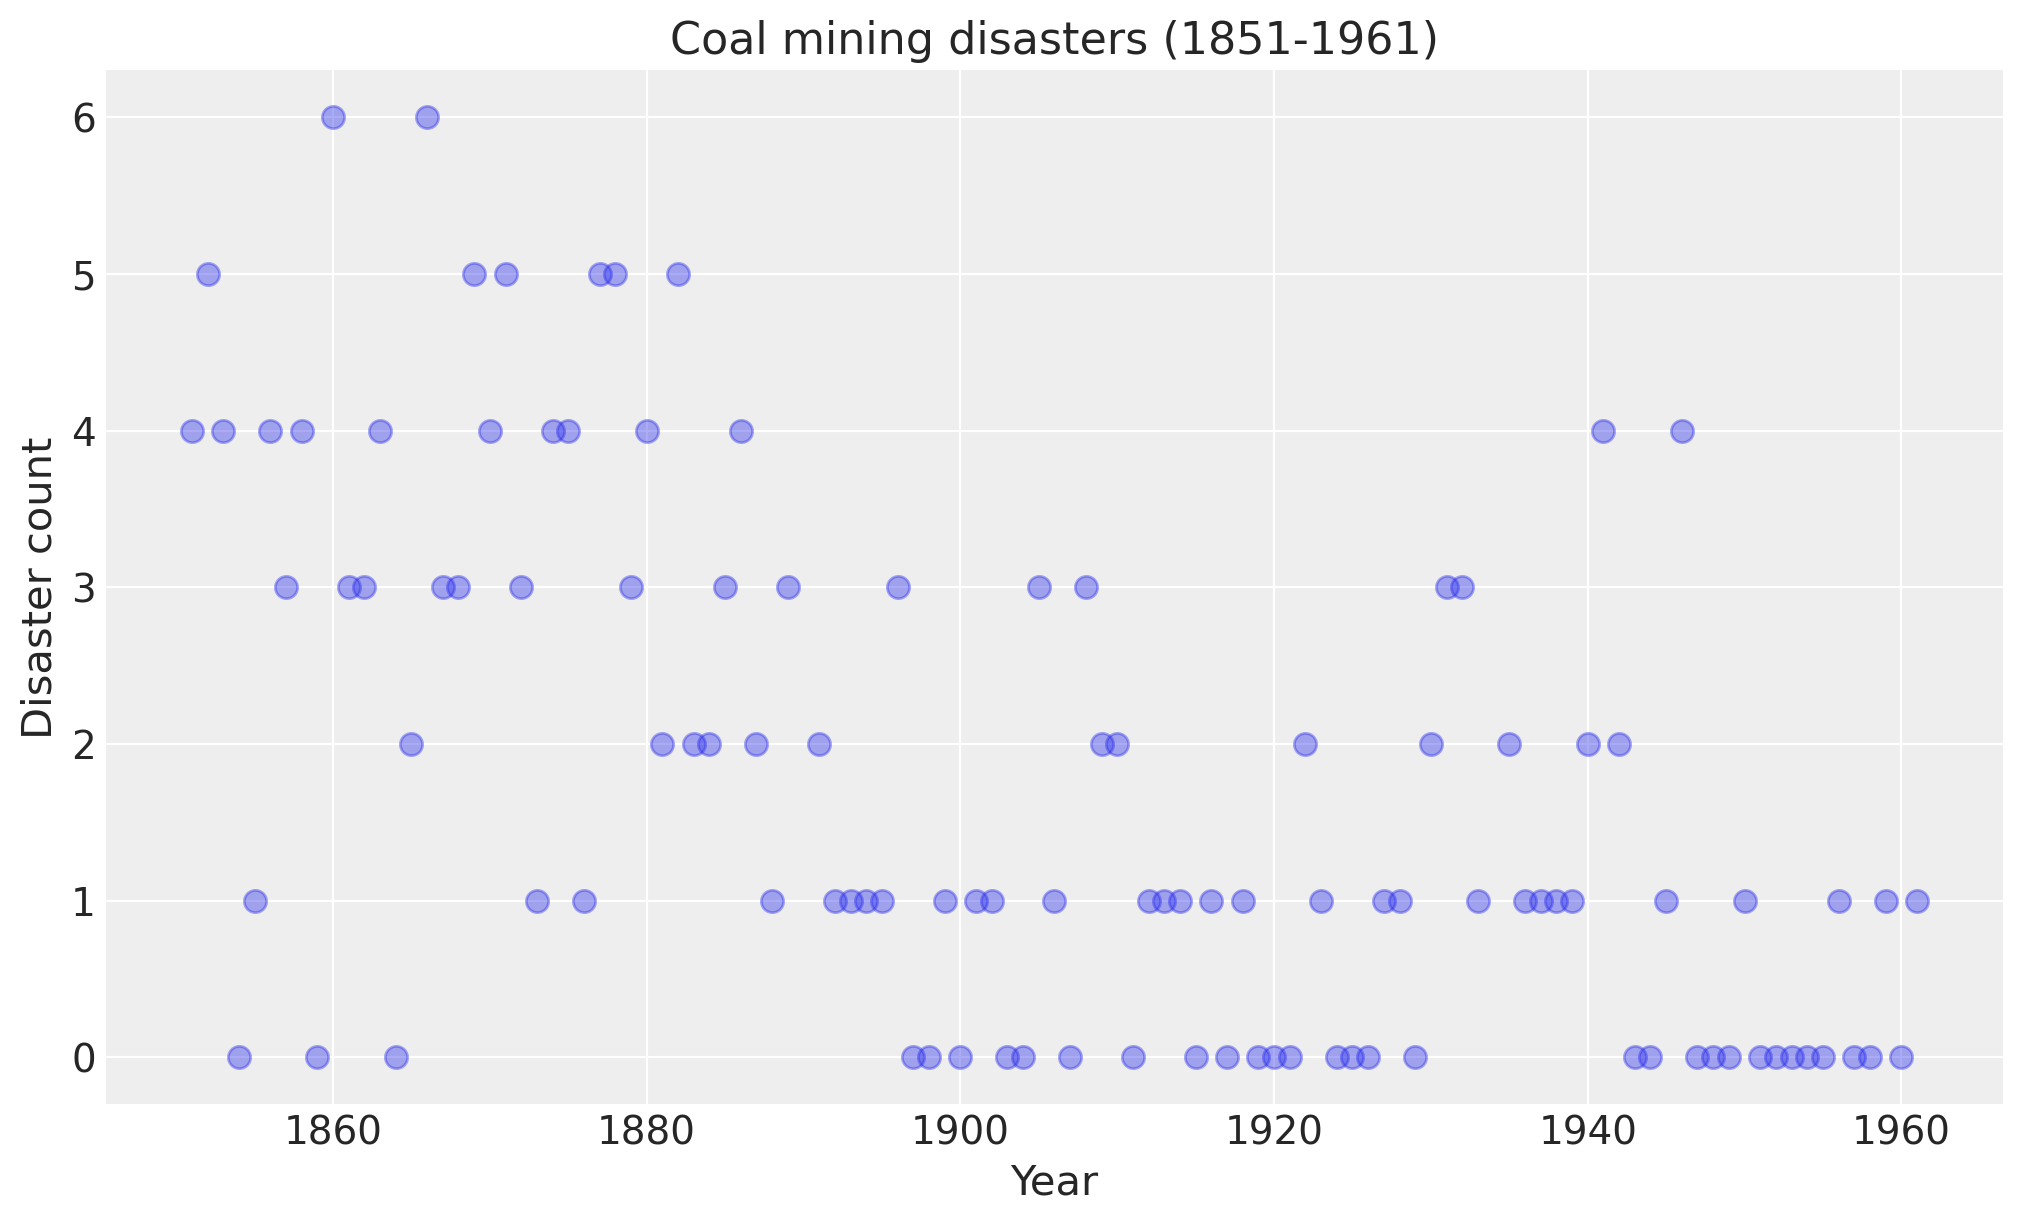

In [22]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.figure(figsize=(10, 6))
plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year")
plt.title("Coal mining disasters (1851-1961)")

# Save the plot
save_path = '/home/dulunche/drclab.github.io-1/static/img/pymc-104/disaster-data.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved disaster data plot to {save_path}")
plt.show()

## Change-Point Model

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which is perhaps related to changes in mining safety regulations.

In our model,

$$
D_t \sim \text{Pois}(r_t), r_t = \begin{cases} 
e, & \text{if } t \leq s \\
l, & \text{if } t > s
\end{cases}
$$

$$s \sim \text{Unif}(t_l, t_h)$$

$$e \sim \exp(1)$$

$$l \sim \exp(1)$$

The parameters are defined as follows:

- $D_t$: The number of disasters in year $t$
- $r_t$: The rate parameter of the Poisson distribution of disasters in year $t$.
- $s$: The year in which the rate parameter changes (the switchpoint).
- $e$: The rate parameter before the switchpoint $s$.
- $l$: The rate parameter after the switchpoint $s$.
- $t_l, t_h$: The lower and upper boundaries of year $t$.

This model is built much like our previous models. The major differences are the introduction of discrete variables with the Poisson and discrete-uniform priors and the novel form of the deterministic random variable `rate`.

In [7]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/home/dulunche/miniconda3/envs/pymc_env/lib/python3.13/site-packages/pymc/model/core.py:1305: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/home/dulunche/miniconda3/envs/pymc_env/lib/python3.13/site-packages/pymc/model/core.py:1319: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


### Implementation Details

The logic for the rate random variable,

```python
rate = switch(switchpoint >= year, early_rate, late_rate)
```

is implemented using `switch`, a function that works like an if statement. It uses the first argument to switch between the next two arguments.

Missing values are handled transparently by passing a NumPy `MaskedArray` or a `DataFrame` with NaN values to the `observed` argument when creating an observed stochastic random variable. Behind the scenes, another random variable, `disasters.missing_values` is created to model the missing values.

Unfortunately, because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling `switchpoint` or the missing disaster observations. Instead, we will sample using a `Metropolis` step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values. PyMC automatically assigns the correct sampling algorithms.

In [8]:
with disaster_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_unobserved]
>NUTS: [early_rate, late_rate]
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_unobserved]
>NUTS: [early_rate, late_rate]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 15 seconds.


Saved trace plot to /home/dulunche/drclab.github.io-1/static/img/pymc-104/trace-plot.png


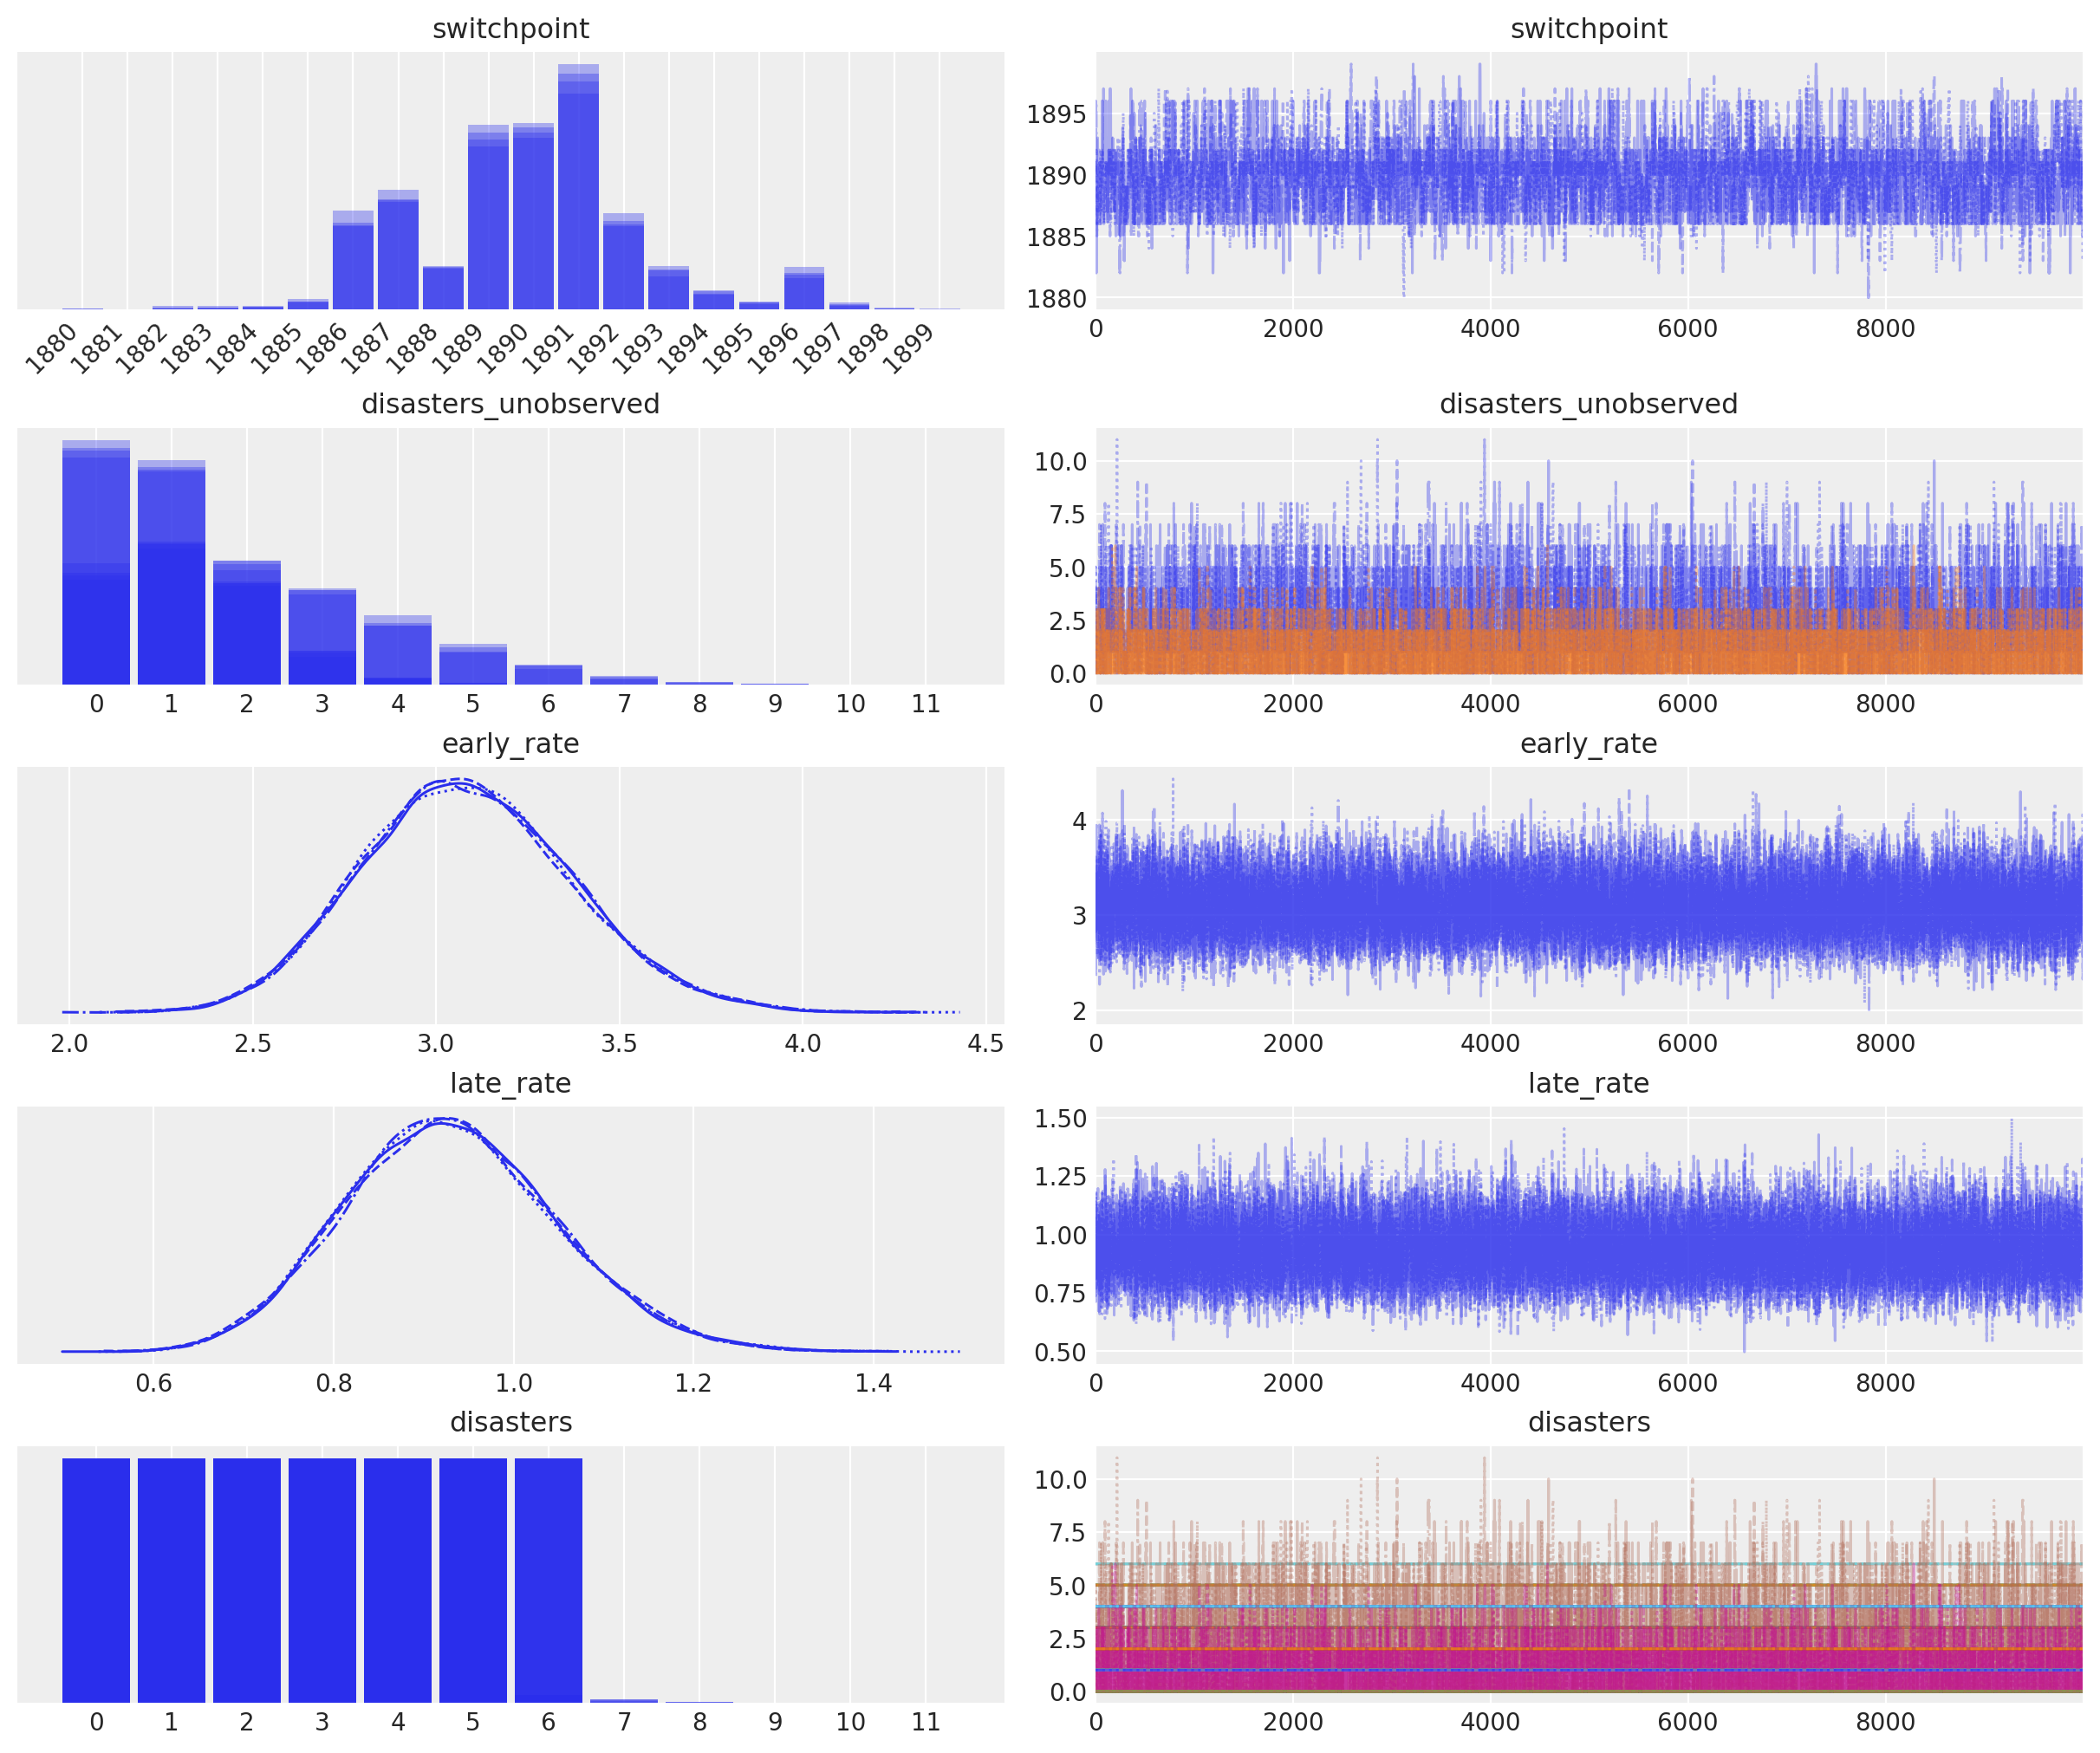

In [23]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

# Save the trace plot
save_path = '/home/dulunche/drclab.github.io-1/static/img/pymc-104/trace-plot.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved trace plot to {save_path}")

### Visualizing the Switchpoint

Note that the `rate` random variable does not appear in the trace. That is fine in this case, because it is not of interest in itself. Remember from the previous example, we would trace the variable by wrapping it in a `Deterministic` class, and giving it a name.

The following plot shows the switch point as an orange vertical line, together with its highest posterior density (HPD) as a semitransparent band. The dashed black line shows the accident rate.

Saved switchpoint visualization to /home/dulunche/drclab.github.io-1/static/img/pymc-104/switchpoint-visualization.png


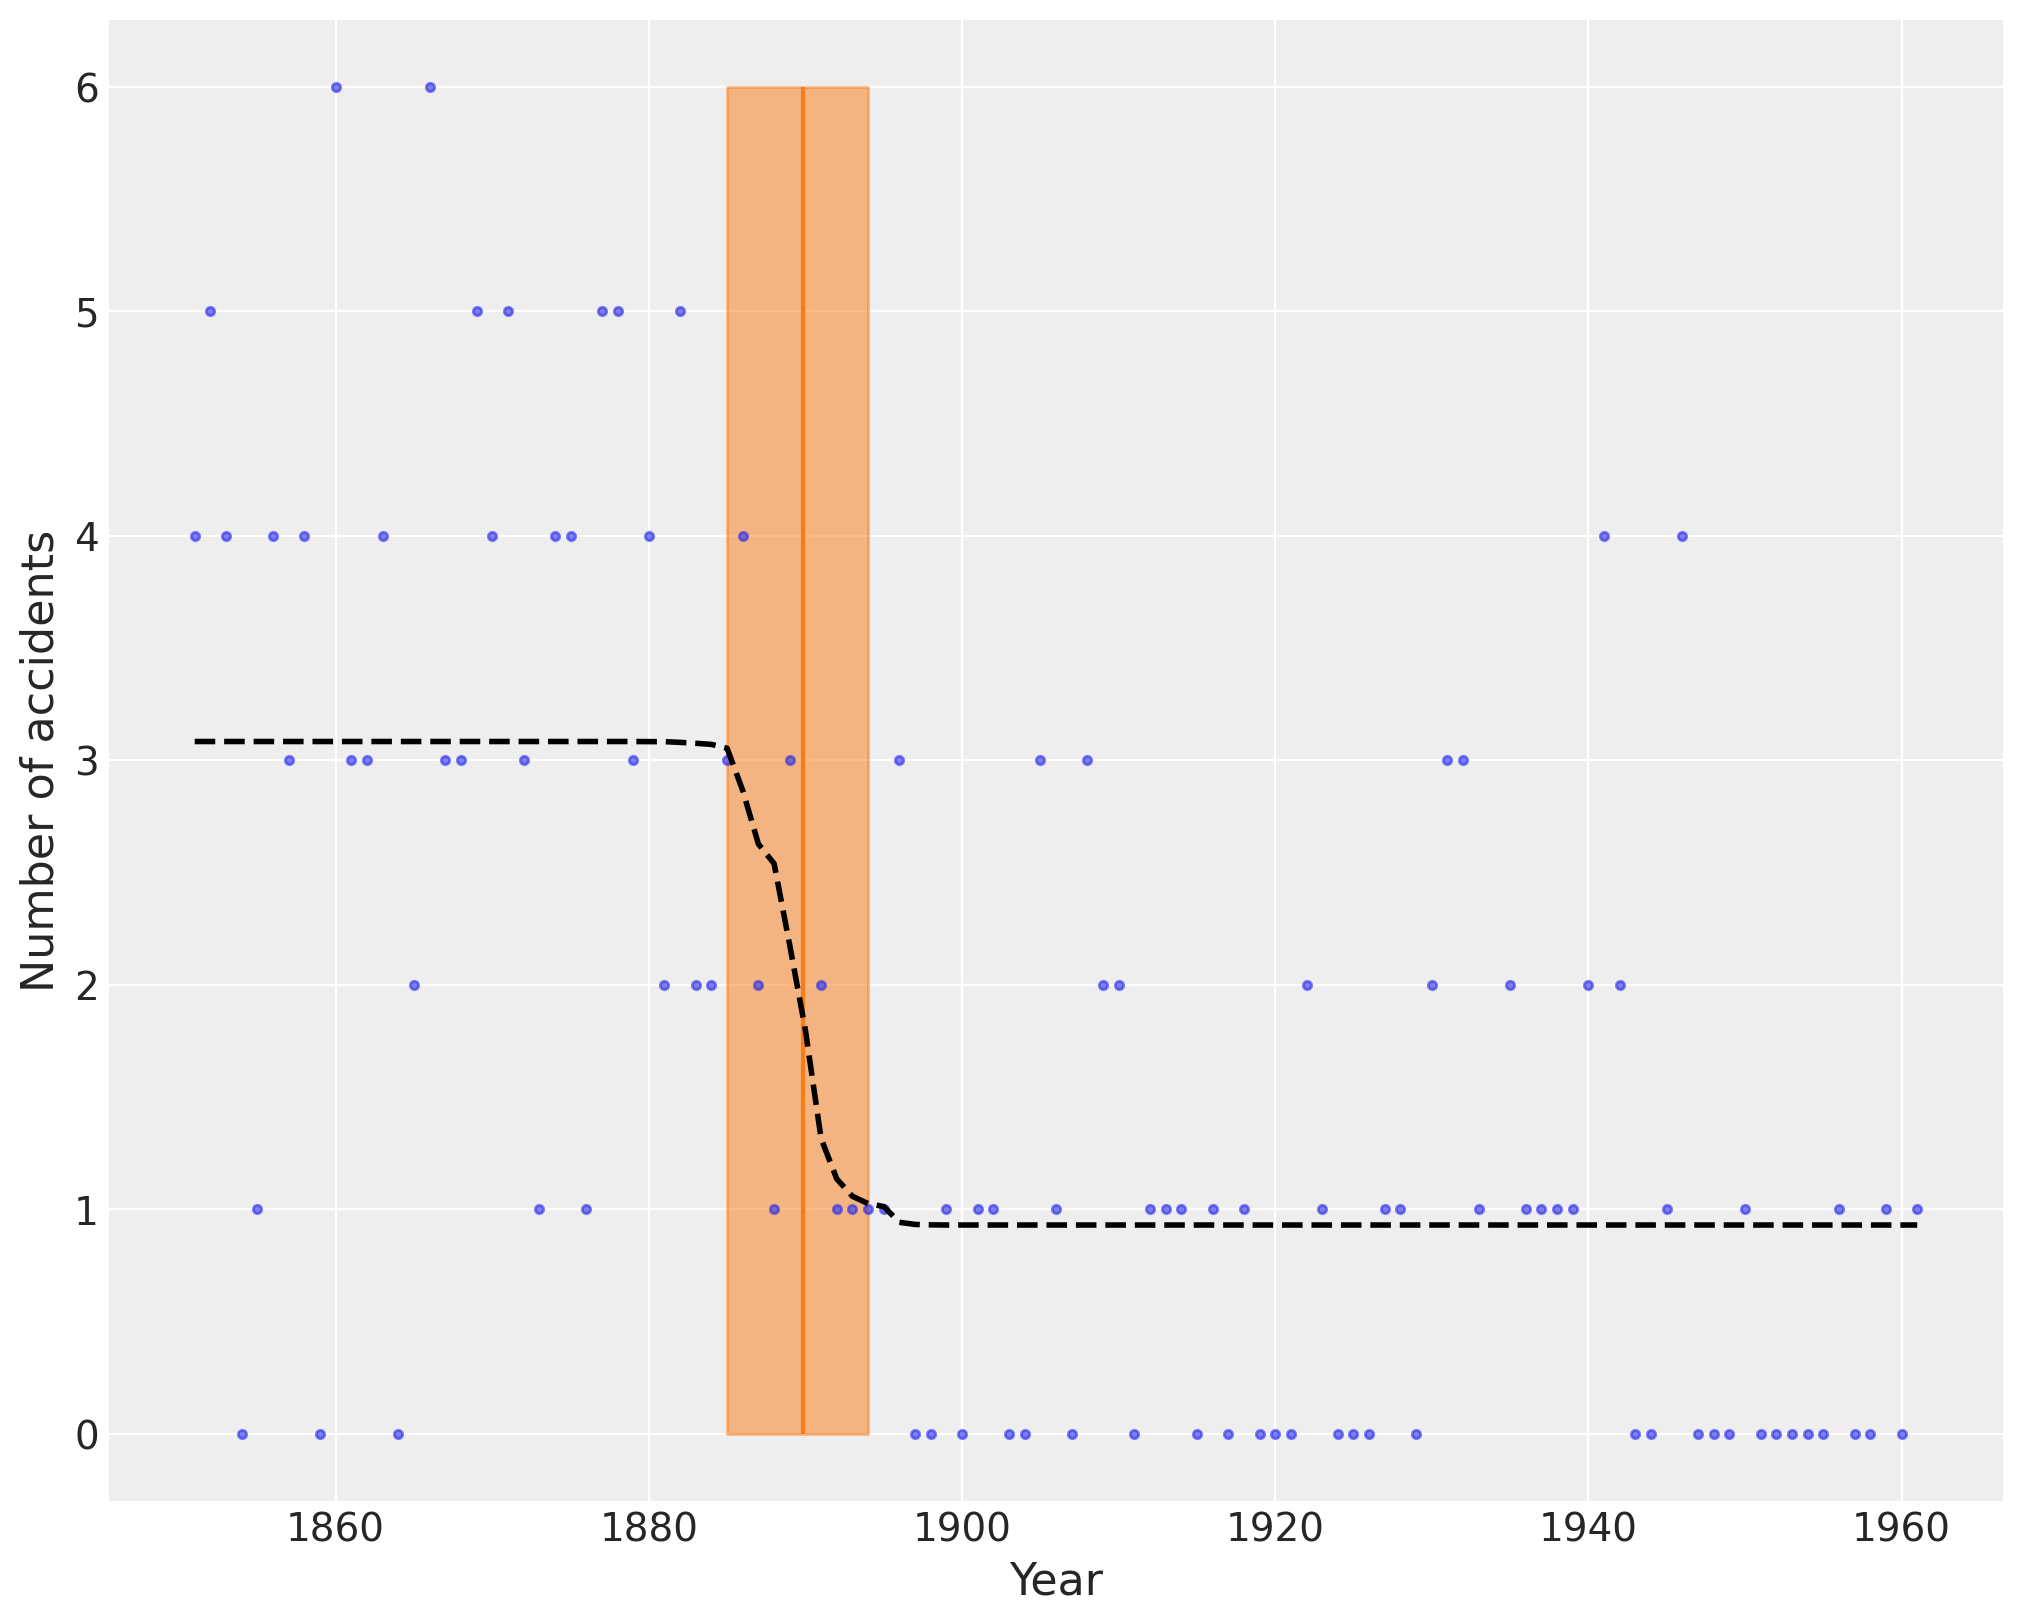

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2)

# Save the switchpoint visualization
save_path = '/home/dulunche/drclab.github.io-1/static/img/pymc-104/switchpoint-visualization.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved switchpoint visualization to {save_path}")
plt.show()

In [20]:
# Print summary statistics
print("=== Model Summary Statistics ===\n")
print(az.summary(idata, var_names=["switchpoint", "early_rate", "late_rate"]))

=== Model Summary Statistics ===

                 mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
switchpoint  1889.865  2.463  1885.000  1894.000      0.050    0.030   
early_rate      3.084  0.286     2.575     3.643      0.002    0.001   
late_rate       0.930  0.117     0.711     1.150      0.001    0.001   

             ess_bulk  ess_tail  r_hat  
switchpoint    2469.0    3982.0    1.0  
early_rate    21472.0   26470.0    1.0  
late_rate     25431.0   25151.0    1.0  


In [21]:
# Show information about missing values
print("\n=== Missing Data Information ===\n")
missing_indices = disaster_data.index[disaster_data.isna()].tolist()
missing_years = [years[i] for i in missing_indices]
print(f"Missing data at indices: {missing_indices}")
print(f"Missing years: {missing_years}")
print(f"\nPosterior samples include imputed values for these missing observations")
print(f"Variable name in trace: 'disasters_unobserved'")


=== Missing Data Information ===

Missing data at indices: [39, 83]
Missing years: [np.int64(1890), np.int64(1934)]

Posterior samples include imputed values for these missing observations
Variable name in trace: 'disasters_unobserved'
